In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Load your data
df = pd.read_excel('../data/Final_data_for_clustering.xlsx')
Borrowings_Table = pd.read_excel("../data/cleaned_borrowings.xlsx")


###  Bar chart showing total borrowings by student year and teachers ###

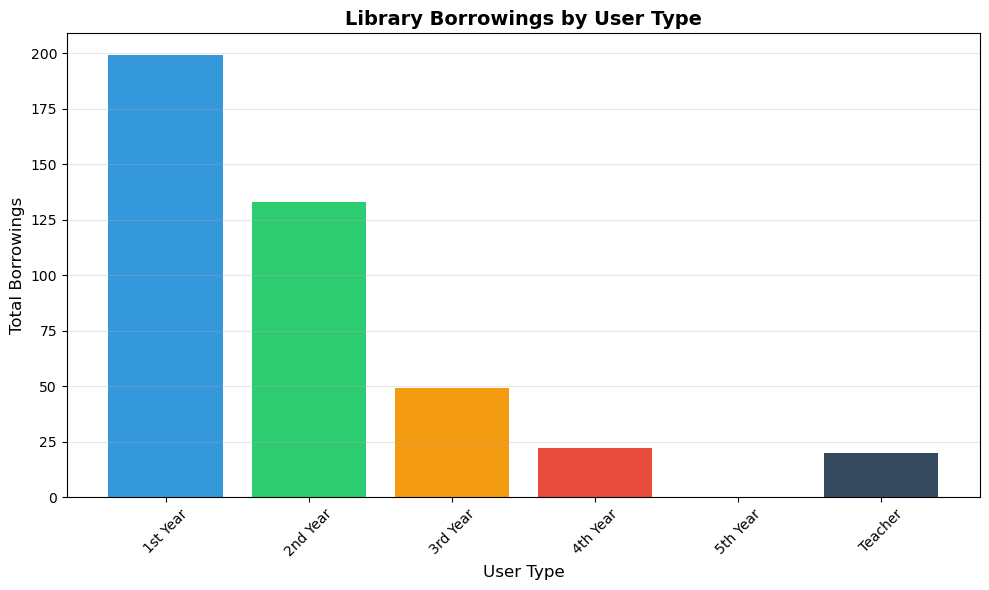

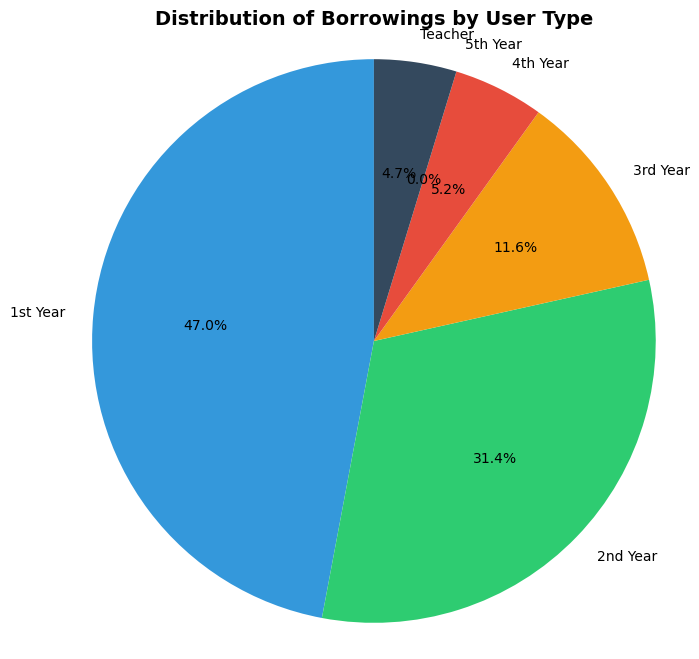

In [4]:


# Sum borrowings by user type
borrowing_by_type = {
    '1st Year': df['1y'].sum(),
    '2nd Year': df['2y'].sum(),
    '3rd Year': df['3y'].sum(),
    '4th Year': df['4y'].sum(),
    '5th Year': df['5y'].sum(),
    'Teacher': df['teacher'].sum()
}

# Create DataFrame for plotting
plot_data = pd.DataFrame(list(borrowing_by_type.items()), 
                         columns=['User Type', 'Total Borrowings'])

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(plot_data['User Type'], plot_data['Total Borrowings'], 
        color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#34495e'])
plt.xlabel('User Type', fontsize=12)
plt.ylabel('Total Borrowings', fontsize=12)
plt.title('Library Borrowings by User Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Pie chart
plt.figure(figsize=(8, 8))
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#34495e']
plt.pie(plot_data['Total Borrowings'], labels=plot_data['User Type'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribution of Borrowings by User Type', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

#### Topic_fr vs year columns ####

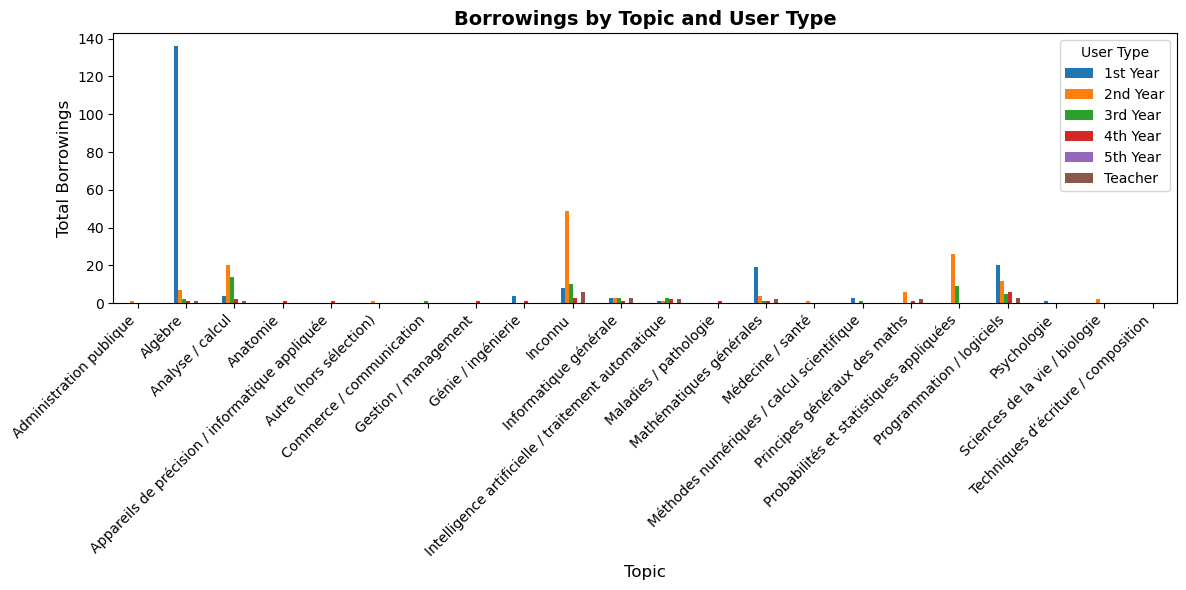

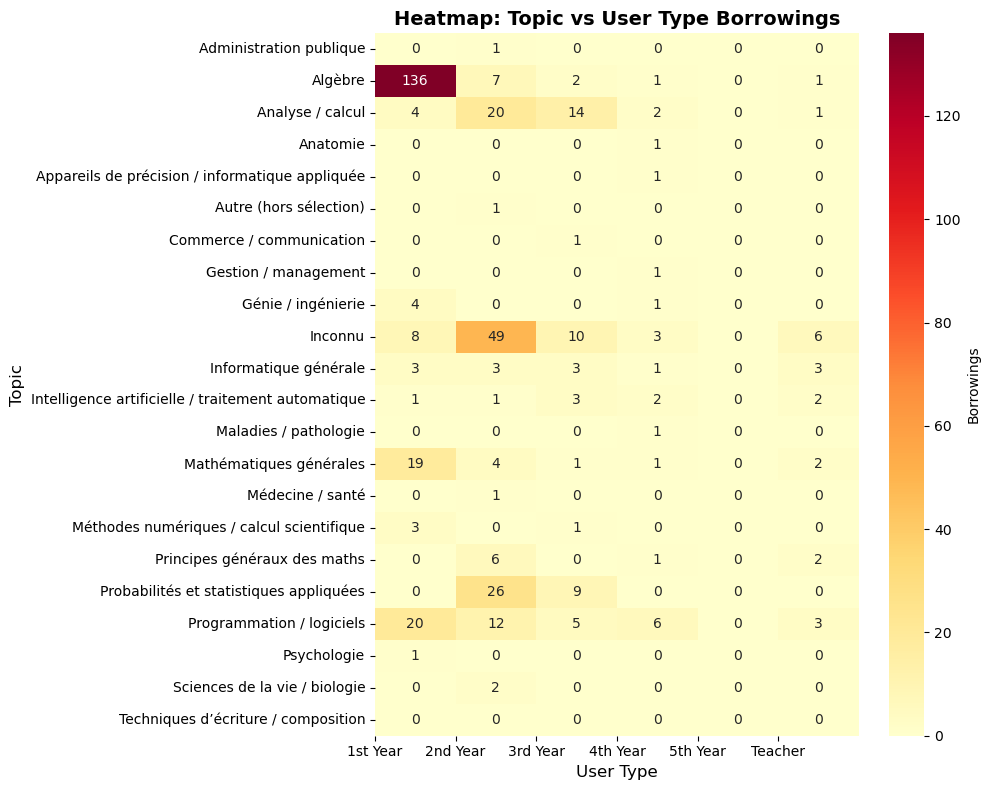

In [5]:

topic_year_data = df.groupby('topic_fr')[['1y', '2y', '3y', '4y', '5y', 'teacher']].sum()

# Bar chart - stacked or grouped
topic_year_data.plot(kind='bar', figsize=(12, 6), stacked=False)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Total Borrowings', fontsize=12)
plt.title('Borrowings by Topic and User Type', fontsize=14, fontweight='bold')
plt.legend(title='User Type', labels=['1st Year', '2nd Year', '3rd Year', '4th Year', '5th Year', 'Teacher'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Alternative: Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(topic_year_data, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'Borrowings'})
plt.xlabel('User Type', fontsize=12)
plt.ylabel('Topic', fontsize=12)
plt.title('Heatmap: Topic vs User Type Borrowings', fontsize=14, fontweight='bold')
plt.xticks(ticks=range(6), labels=['1st Year', '2nd Year', '3rd Year', '4th Year', '5th Year', 'Teacher'])
plt.tight_layout()
plt.show()

### Semester vs Topic ####

<Figure size 1000x600 with 0 Axes>

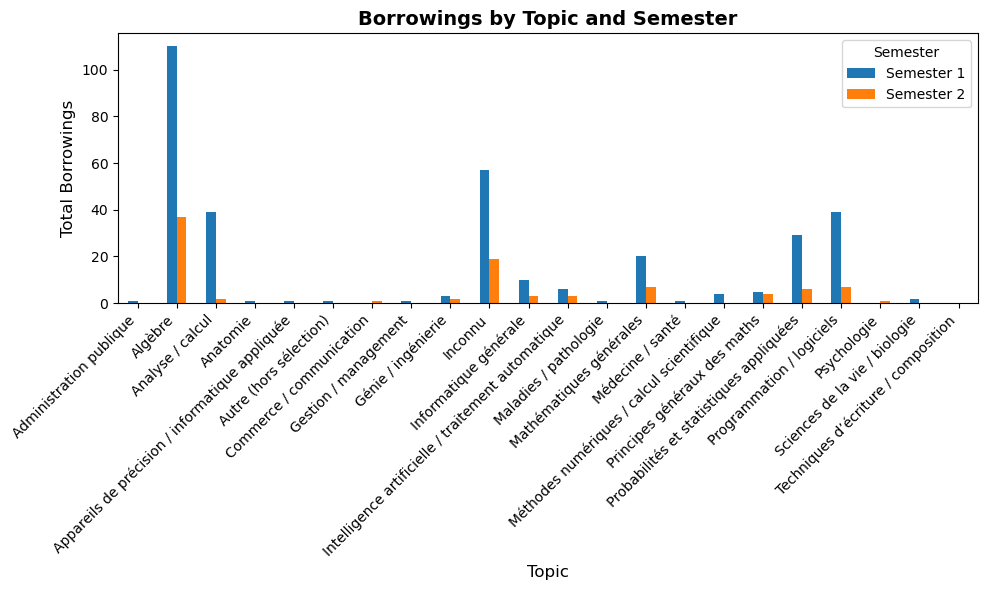

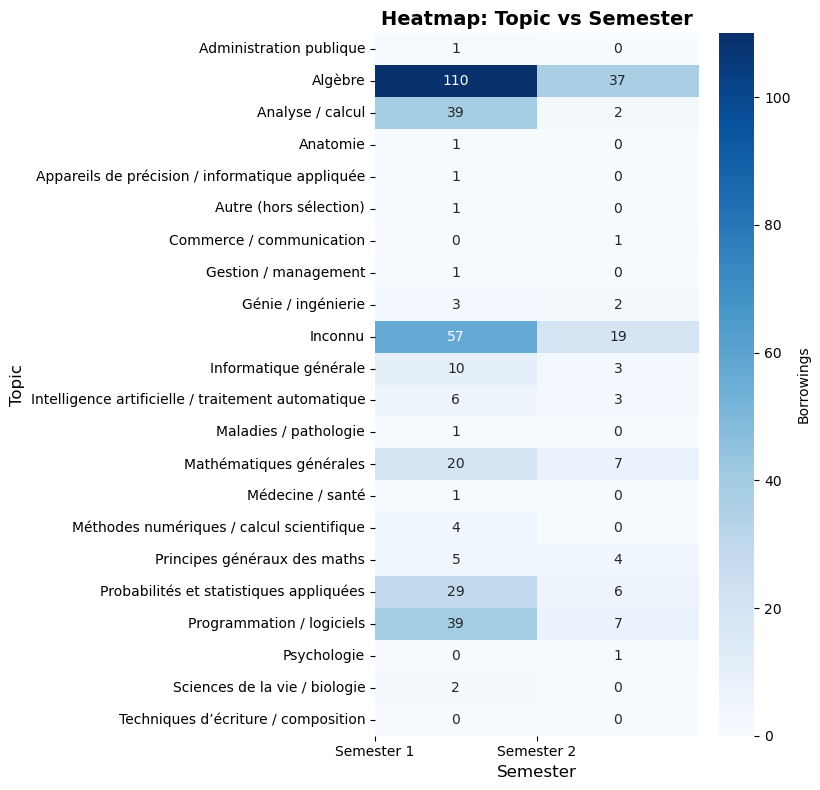

In [6]:

semester_topic = df.groupby('topic_fr')[['semester_1', 'semester_2']].sum()

plt.figure(figsize=(10, 6))
semester_topic.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Total Borrowings', fontsize=12)
plt.title('Borrowings by Topic and Semester', fontsize=14, fontweight='bold')
plt.legend(title='Semester', labels=['Semester 1', 'Semester 2'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#  Heatmap 
plt.figure(figsize=(8, 8))
sns.heatmap(semester_topic, annot=True, fmt='g', cmap='Blues', cbar_kws={'label': 'Borrowings'})
plt.xlabel('Semester', fontsize=12)
plt.ylabel('Topic', fontsize=12)
plt.title('Heatmap: Topic vs Semester', fontsize=14, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['Semester 1', 'Semester 2'])
plt.tight_layout()
plt.show()

## Book Ctegory

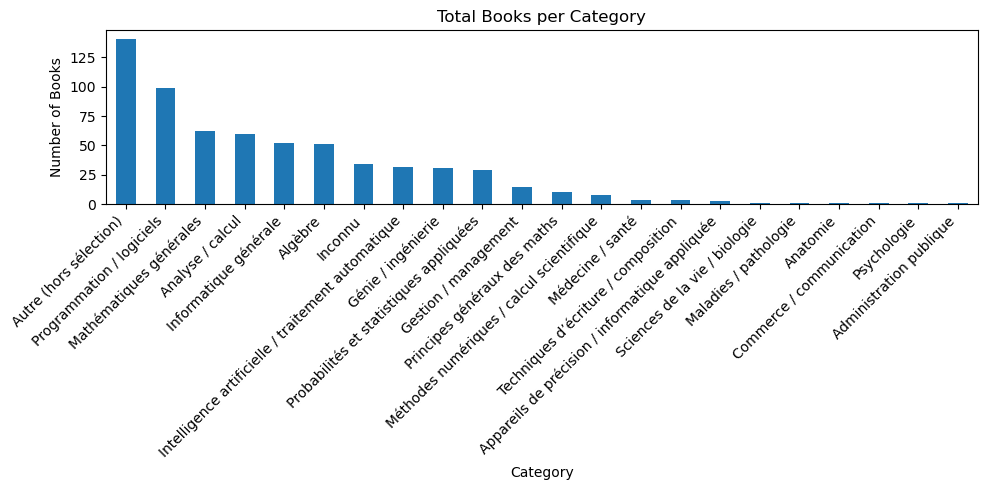

In [7]:
category_counts = df["topic_fr"].value_counts()
category_counts.plot(kind="bar", figsize=(10,5))
plt.title("Total Books per Category")
plt.xlabel("Category")
plt.ylabel("Number of Books")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

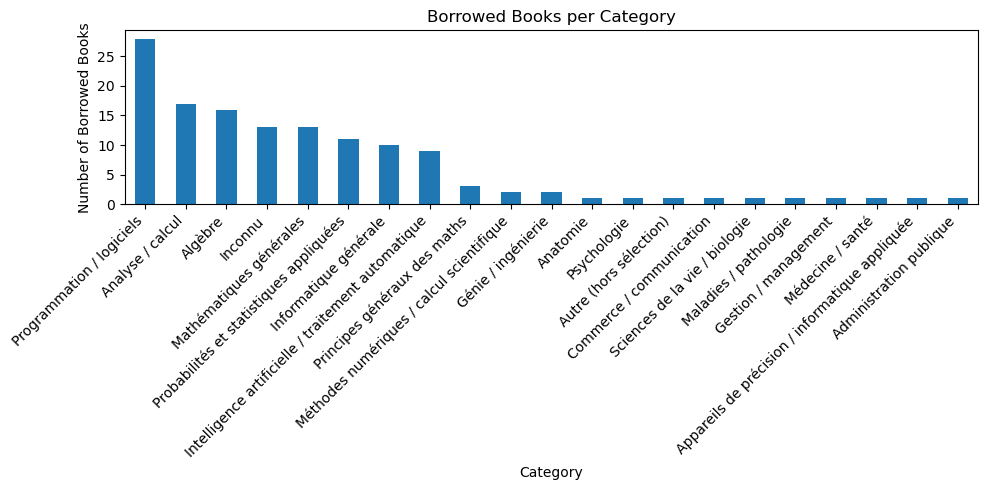

In [8]:
borrowed_df = df[df["total_borrowed"] > 0]

borrowed_category_counts = borrowed_df["topic_fr"].value_counts()
borrowed_category_counts.plot(kind="bar", figsize=(10,5))
plt.title("Borrowed Books per Category")
plt.xlabel("Category")
plt.ylabel("Number of Borrowed Books")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Borrowing Analysis

In [9]:
# Group by user to create transactions
Borrowings_transactions = Borrowings_Table.groupby("N° lecteur")["Titre_clean"].apply(list).reset_index()

# Calculate number of books per user
Borrowings_transactions['num_books_borrowed'] = Borrowings_transactions['Titre_clean'].apply(len)

print(f"Total Users: {len(Borrowings_transactions)}")
print(f"Total Borrowings: {len(Borrowings_Table)}")
print(f"Average Books per User: {Borrowings_transactions['num_books_borrowed'].mean():.2f}")

Total Users: 271
Total Borrowings: 422
Average Books per User: 1.56


**Categorize users by borrowing behavior**

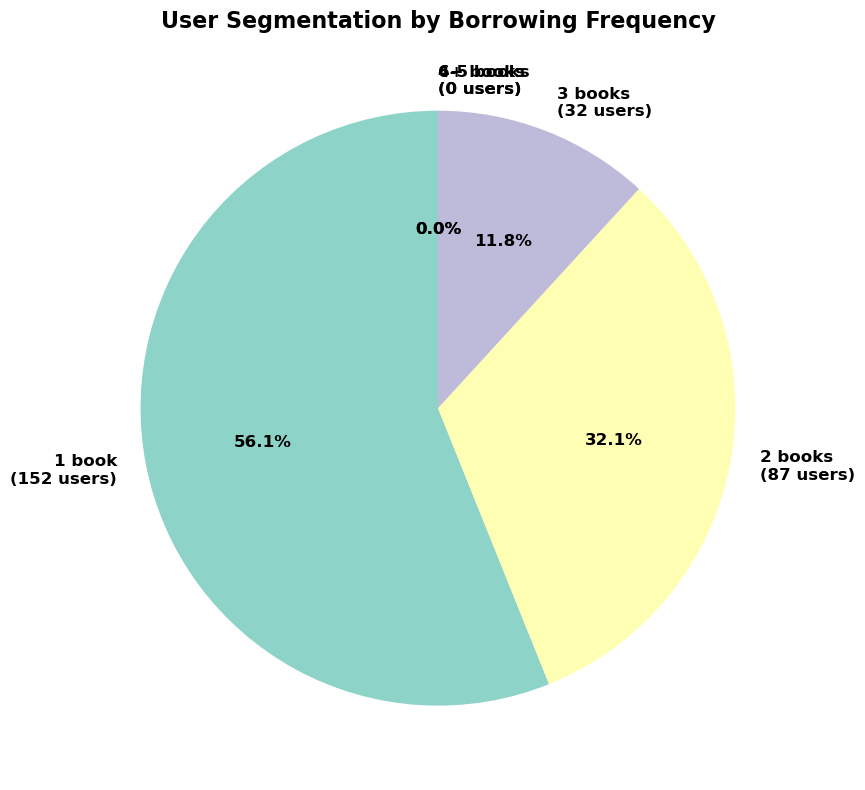

In [10]:
plt.figure(figsize=(10, 8))

# Create borrowing categories
borrowing_categories = pd.cut(Borrowings_transactions['num_books_borrowed'],
                              bins=[0, 1, 2, 3, 5, float('inf')],
                              labels=['1 book', '2 books', '3 books', '4-5 books', '6+ books'])

category_counts = borrowing_categories.value_counts().sort_index()

# Create pie chart
colors = plt.cm.Set3(range(len(category_counts)))
wedges, texts, autotexts = plt.pie(category_counts, 
                                     labels=category_counts.index,
                                     autopct='%1.1f%%',
                                     startangle=90,
                                     colors=colors,
                                     textprops={'fontsize': 12, 'fontweight': 'bold'})

# Add counts to labels
for i, (label, count) in enumerate(zip(category_counts.index, category_counts.values)):
    texts[i].set_text(f'{label}\n({count} users)')

plt.title('User Segmentation by Borrowing Frequency', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('user_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()